In [1]:
import shap
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
test_data = joblib.load('test_data.pkl')

X_test = test_data['X_test']
y_test = test_data['y_test']
X_log_test = test_data['X_log_test']
y_log_test = test_data['y_log_test']
features = test_data['features']
targets = test_data['targets']

print('Features: ', features)
print('Targets: ', targets)

Features:  ['U10', 'c2h6', 'oh', 'c5h8', 'hno3', 'no2', 'no', 'go3', 'c3h8', 'so2', 't', 'nox', 'voc', 'rh']
Targets:  ['pm2p5', 'pm10']


In [3]:
rf_model = joblib.load('rf_best_model.pkl')
rf_log_model = joblib.load('rf_best_model_log.pkl')
xgb_model = joblib.load('xgb_best_model_log.pkl')

In [4]:
def model_performance(
    model,
    X_test,
    y_test,
    targets,
    model_name
):
    results = {}
    for i, target in enumerate(targets):
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i]))
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])

        results[target] = {
            'Model': model_name,
            'RMSE': rmse,
            'MAE': mae,
            'MSE': mse,
            'R2': r2
        }
    return pd.DataFrame(results).T


In [5]:
rf_metrics = model_performance(rf_model, X_test, y_test, targets, 'Random Forest')
rf_log_metrics = model_performance(rf_log_model, X_log_test, y_log_test, targets, 'Random Forest (Log)')
xgb_metrics = model_performance(xgb_model, X_test, y_test, targets, 'XGBoost')

combined_metrics = pd.concat([rf_metrics, rf_log_metrics, xgb_metrics])

combined_metrics.to_csv('model_performance.csv')

In [6]:
combined_metrics

,Model,RMSE,MAE,MSE,R2
pm2p5,Random Forest,5.639773,3.864653,31.807039,0.676734
pm10,Random Forest,7.59973,5.312308,57.7559,0.688874
pm2p5,Random Forest (Log),0.513505,0.364176,0.263687,0.494942
pm10,Random Forest (Log),0.544191,0.37902,0.296144,0.479778
pm2p5,XGBoost,6.008836,3.984461,36.106106,0.633042
pm10,XGBoost,8.130779,5.467815,66.109566,0.643873


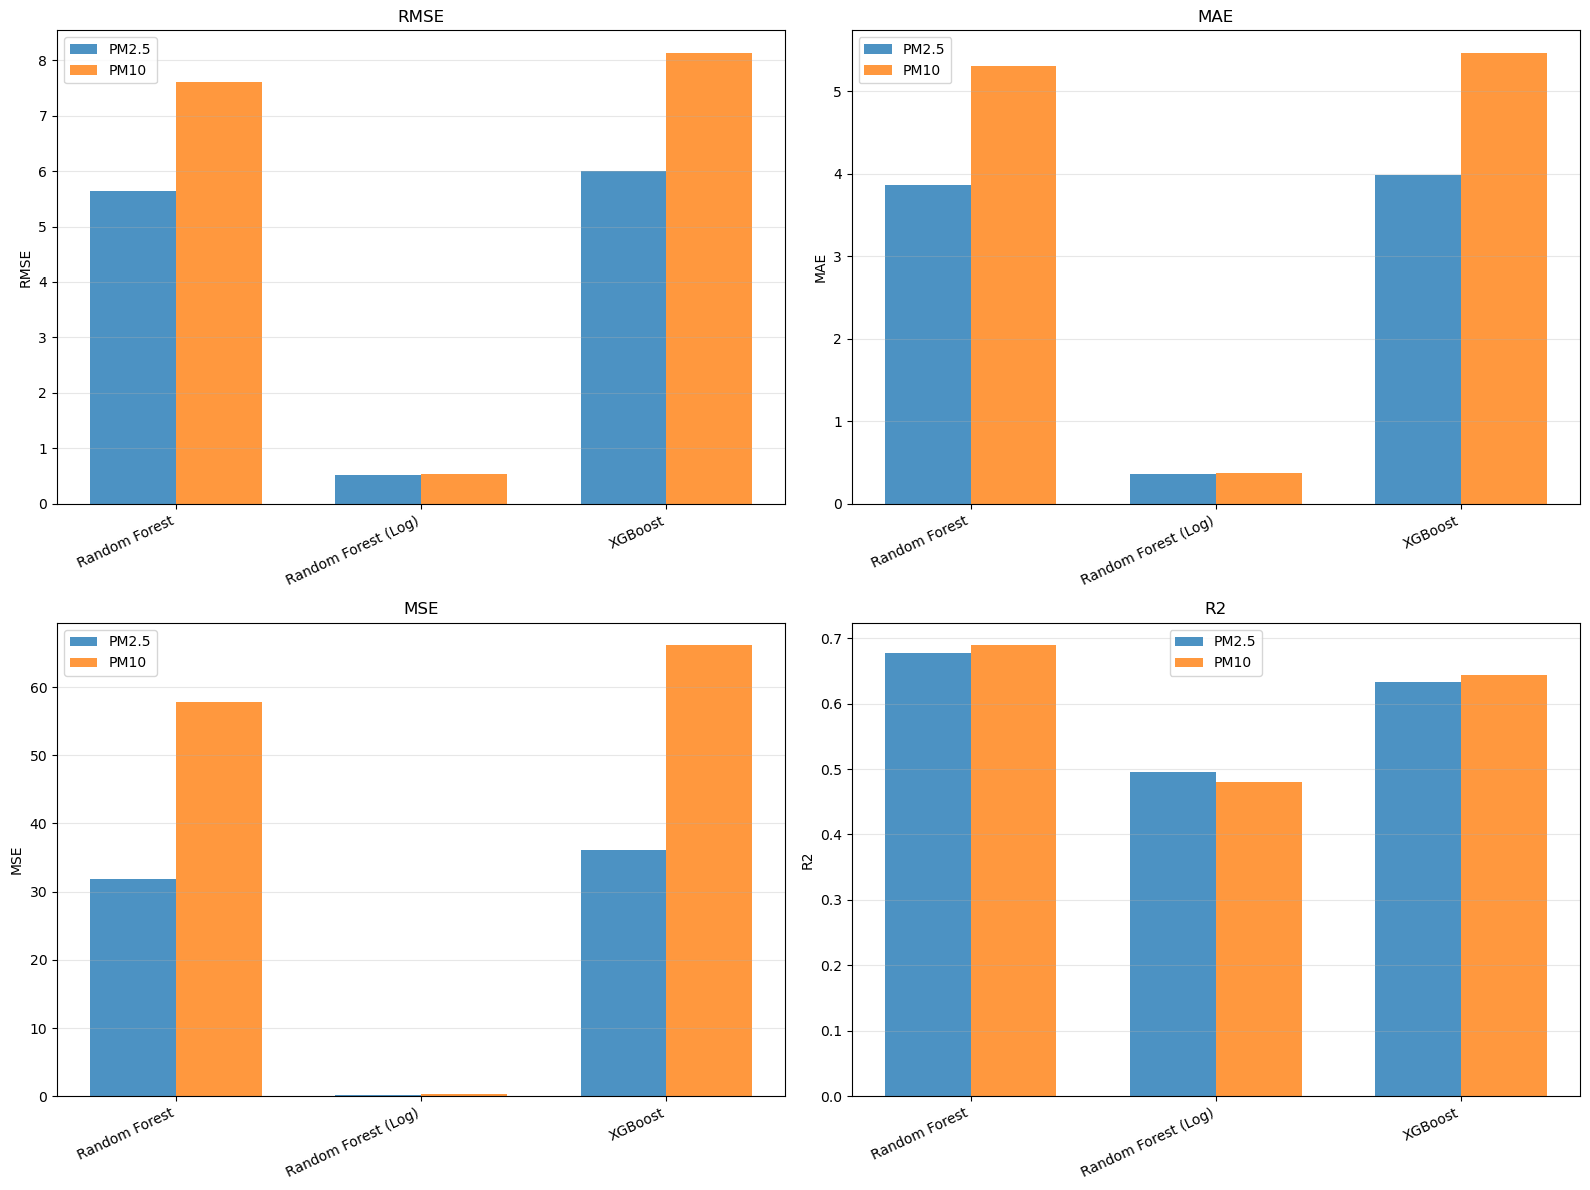

In [7]:
metrics_plot = combined_metrics.reset_index()
metrics_plot = metrics_plot.rename(columns={'index': 'Target'})

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics_to_plot = ['RMSE', 'MAE', 'MSE', 'R2']

for ax, metric in zip(axes.flat, metrics_to_plot):
    pm25_data = metrics_plot[metrics_plot['Target'] == 'pm2p5']
    pm10_data = metrics_plot[metrics_plot['Target'] == 'pm10']
    
    x = np.arange(len(pm25_data))
    width = 0.35
    
    ax.bar(x - width/2, pm25_data[metric], width, label='PM2.5', alpha=0.8)
    ax.bar(x + width/2, pm10_data[metric], width, label='PM10', alpha=0.8)
    
    ax.set_ylabel(metric)
    ax.set_title(f'{metric}')
    ax.set_xticks(x)
    ax.set_xticklabels(pm25_data['Model'], rotation=25, ha='right')
    ax.legend(loc='best')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()

Text(0.5, 1.0, 'Feature Importances for Random Forest')

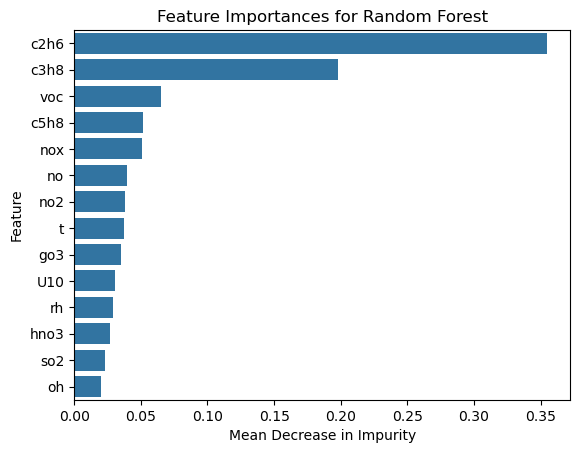

In [8]:
# Random Forest Feature Importance (Gini)
rf_importances = pd.DataFrame({
    'Feature': features,
    'Mean Decrease in Impurity': rf_model.feature_importances_
})
rf_importances = rf_importances.sort_values(by='Mean Decrease in Impurity', ascending=False)

sns.barplot(data=rf_importances, x='Mean Decrease in Impurity', y='Feature')

plt.title('Feature Importances for Random Forest')

Text(0.5, 1.0, 'Feature Importances for Random Forest (Log)')

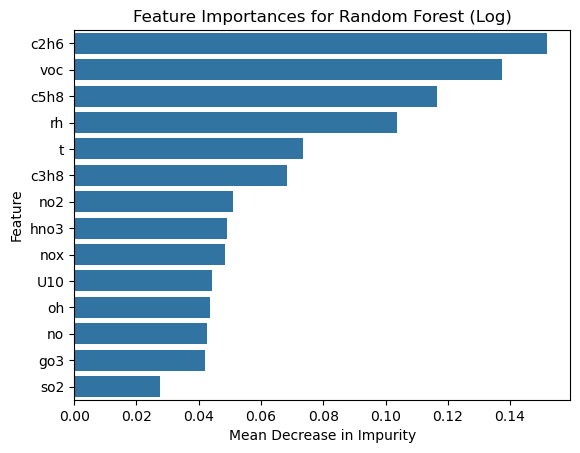

In [9]:
# Random Forest (Log) Feature Importance (Gini)
rf_log_importances = pd.DataFrame({'Feature': features, 'Mean Decrease in Impurity': rf_log_model.feature_importances_})
rf_log_importances = rf_log_importances.sort_values(by='Mean Decrease in Impurity', ascending=False)

sns.barplot(data=rf_log_importances, x='Mean Decrease in Impurity', y='Feature')

plt.title('Feature Importances for Random Forest (Log)')

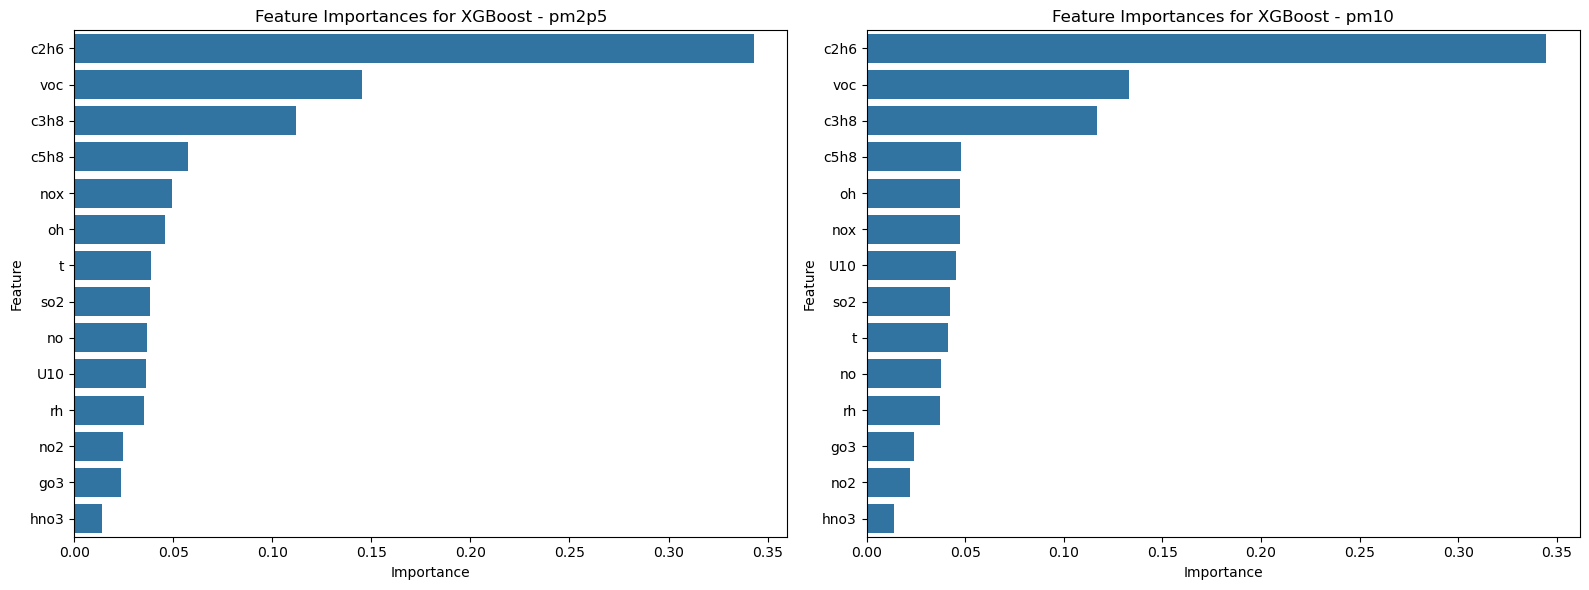

In [10]:
# XGBoost has individual models for each target
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, (ax, target) in enumerate(zip(axes, targets)):
    xgb_imp = pd.DataFrame({
        'Feature': features,
        'Importance': xgb_model.estimators_[i].feature_importances_
    }).sort_values('Importance', ascending=False)
    
    sns.barplot(data=xgb_imp, x='Importance', y='Feature', ax=ax)
    ax.set_title(f'Feature Importances for XGBoost - {target}')

plt.tight_layout()

In [11]:
rf_pred = rf_model.predict(X_test)
rf_log_pred = np.expm1(rf_log_model.predict(X_log_test))
xgb_pred = xgb_model.predict(X_test)

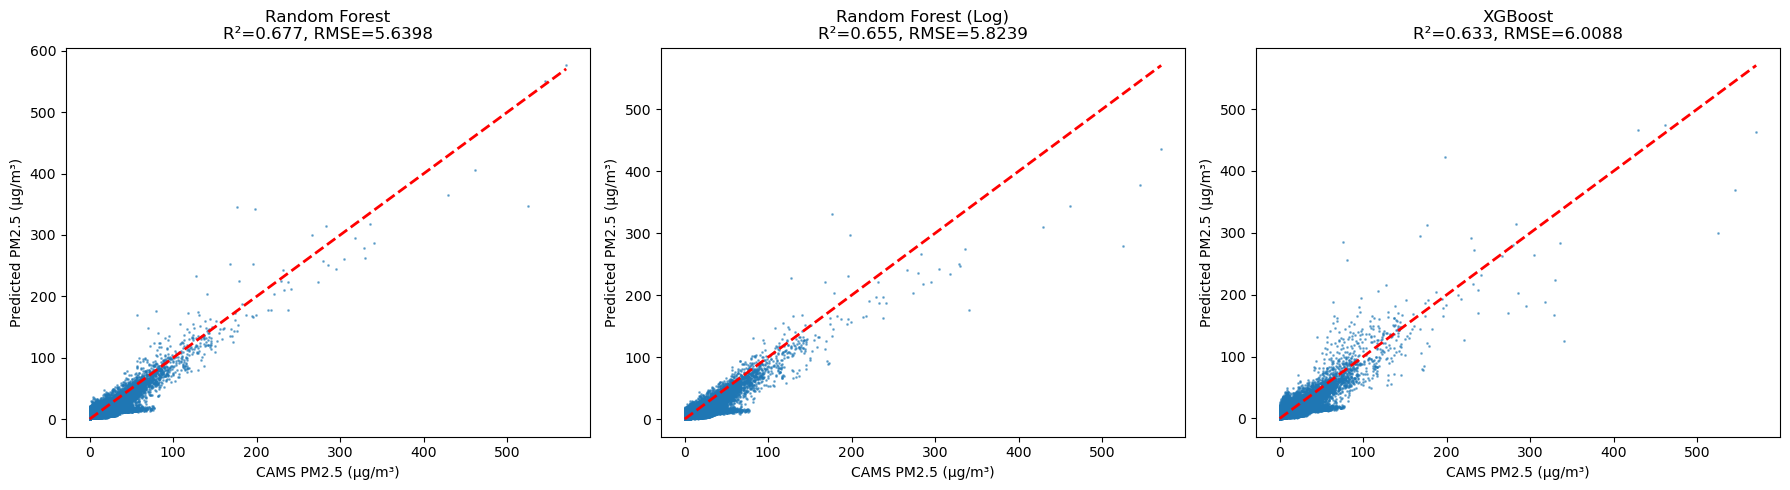

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
models_pred = [rf_pred, rf_log_pred, xgb_pred]
model_names = ['Random Forest', 'Random Forest (Log)', 'XGBoost']

for i, (ax, pred, name) in enumerate(zip(axes, models_pred, model_names)):
    ax.scatter(y_test.iloc[:, 0], pred[:, 0], alpha=0.5, s=1)
    ax.plot([y_test.iloc[:, 0].min(), y_test.iloc[:, 0].max()], 
            [y_test.iloc[:, 0].min(), y_test.iloc[:, 0].max()], 
            'r--', lw=2)
    
    r2 = r2_score(y_test.iloc[:, 0], pred[:, 0])
    rmse = np.sqrt(mean_squared_error(y_test.iloc[:, 0], pred[:, 0]))
    
    ax.set_xlabel('CAMS PM2.5 (µg/m³)')
    ax.set_ylabel('Predicted PM2.5 (µg/m³)')
    ax.set_title(f'{name}\nR²={r2:.3f}, RMSE={rmse:.4f}')

plt.tight_layout()

The difference in the R2 values between the Random Forest model and the Random Forest model run on the log-transformed data seems negligble/random. The Random Forest model performs better than the XGBoost model. I will proceed with examining the Random Forest model with a focus on PM2.5 as the target variable.

In [13]:
sample_indices = np.random.RandomState(12).choice(len(X_test), size=10, replace=False)
X_shap_sample = X_test.iloc[sample_indices]

In [14]:
rf_explainer = shap.TreeExplainer(rf_model)
rf_shap_vals = rf_explainer(X_shap_sample)

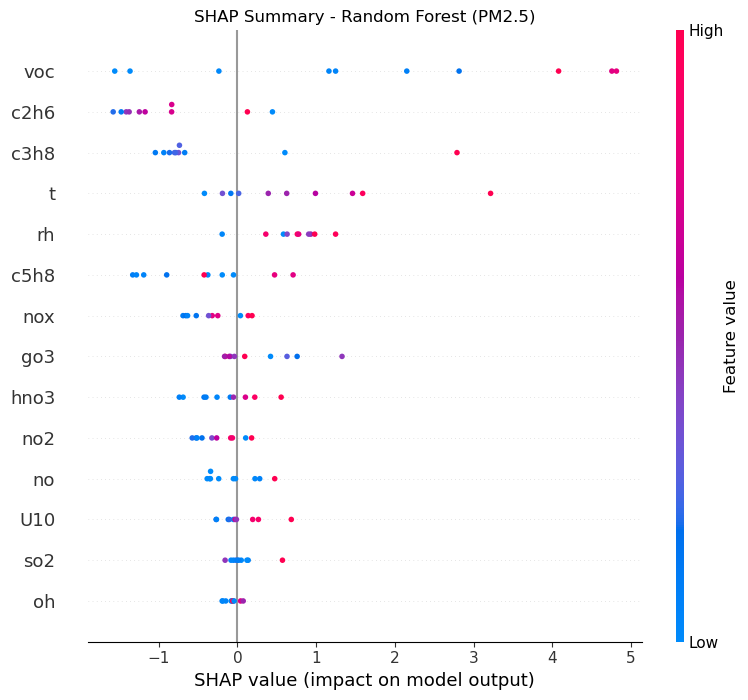

In [15]:
fig, ax = plt.subplots(figsize=(16, 12))

shap.summary_plot(rf_shap_vals[:, :, 0], show=False)  # Different indexing
ax.set_title('SHAP Summary - Random Forest (PM2.5)')

plt.tight_layout()

Text(0.5, 1.0, 'SHAP Feature Importance - Random Forest (PM2.5)')

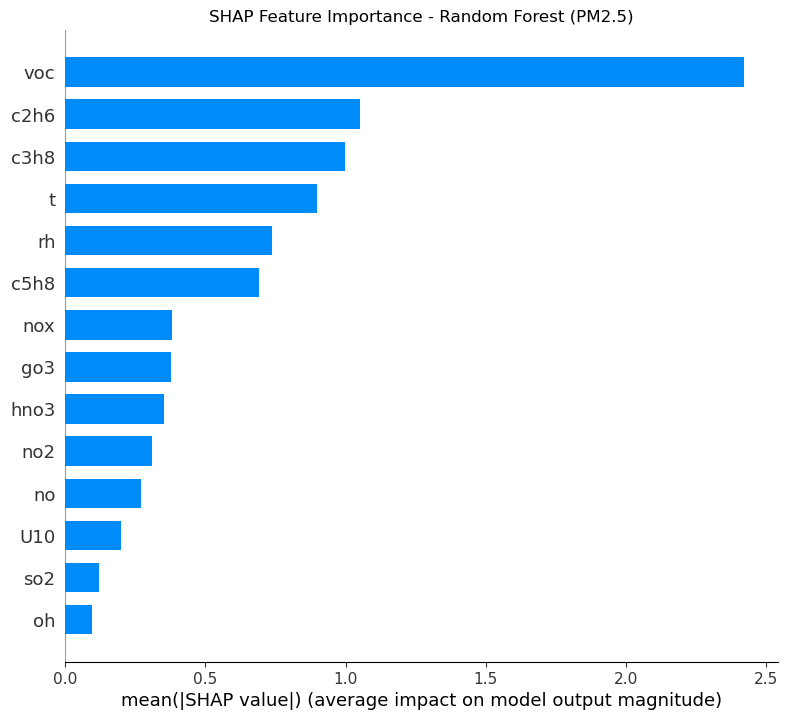

In [16]:
fig, ax = plt.subplots(figsize=(16, 12))

shap.summary_plot(rf_shap_vals[:, :, 0], plot_type='bar', show=False)
ax.set_title('SHAP Feature Importance - Random Forest (PM2.5)')

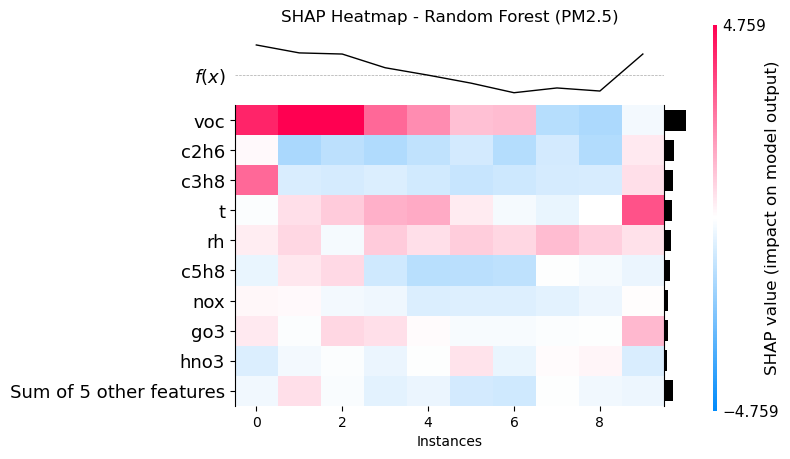

In [17]:
shap.plots.heatmap(rf_shap_vals[:, :, 0], show=False)
plt.title('SHAP Heatmap - Random Forest (PM2.5)')
plt.tight_layout()

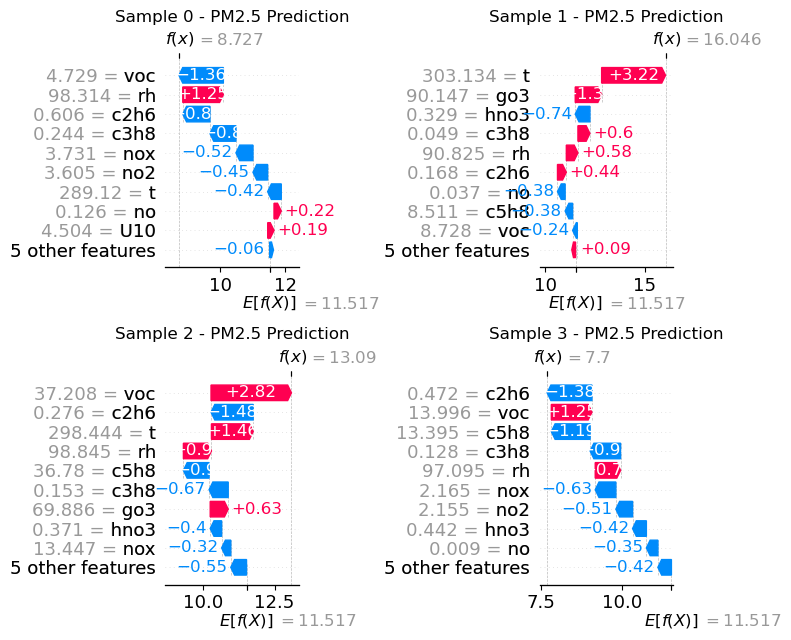

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for i in range(4):
    plt.sca(axes[i])
    shap.waterfall_plot(rf_shap_vals[i, :, 0], show=False)
    axes[i].set_title(f'Sample {i} - PM2.5 Prediction')

plt.tight_layout()

In [19]:
# Read in monitored data from AQS pre-generated data files
aqs_2022 = pd.read_csv('data/daily_88101_2022.csv')
aqs_2023 = pd.read_csv('data/daily_88101_2023.csv')
aqs_2024 = pd.read_csv('data/daily_88101_2024.csv')

aqs_data = pd.concat([aqs_2022, aqs_2023, aqs_2024])

/tmp/ipykernel_3076240/188353014.py:4: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  aqs_2024 = pd.read_csv('data/daily_88101_2024.csv')


In [20]:
aqs_data.columns

Index(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Sample Duration',
       'Pollutant Standard', 'Date Local', 'Units of Measure', 'Event Type',
       'Observation Count', 'Observation Percent', 'Arithmetic Mean',
       '1st Max Value', '1st Max Hour', 'AQI', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'State Name', 'County Name', 'City Name',
       'CBSA Name', 'Date of Last Change'],
      dtype='object')

In [21]:
# Use same domain as CAMS query
aqs_filtered = aqs_data[
    (aqs_data['Latitude'] >= 30) & 
    (aqs_data['Latitude'] <= 36) &
    (aqs_data['Longitude'] >= -86) & 
    (aqs_data['Longitude'] <= -80)
].copy()

In [22]:
aqs_filtered

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,...,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
115,1,27,1,88101,1,33.284928,-85.803608,NAD83,PM2.5 - Local Conditions,24 HOUR,...,15.0,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,ASHLAND,ASHLAND AIRPORT,Alabama,Clay,Ashland,NaN,5/17/2024
116,1,27,1,88101,1,33.284928,-85.803608,NAD83,PM2.5 - Local Conditions,24 HOUR,...,32.0,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,ASHLAND,ASHLAND AIRPORT,Alabama,Clay,Ashland,NaN,5/17/2024
117,1,27,1,88101,1,33.284928,-85.803608,NAD83,PM2.5 - Local Conditions,24 HOUR,...,27.0,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,ASHLAND,ASHLAND AIRPORT,Alabama,Clay,Ashland,NaN,5/17/2024
118,1,27,1,88101,1,33.284928,-85.803608,NAD83,PM2.5 - Local Conditions,24 HOUR,...,11.0,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,ASHLAND,ASHLAND AIRPORT,Alabama,Clay,Ashland,NaN,5/17/2024
119,1,27,1,88101,1,33.284928,-85.803608,NAD83,PM2.5 - Local Conditions,24 HOUR,...,24.0,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,ASHLAND,ASHLAND AIRPORT,Alabama,Clay,Ashland,NaN,5/17/2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609941,47,145,4,88101,3,35.939078,-84.542802,WGS84,PM2.5 - Local Conditions,24-HR BLK AVG,...,52.0,209,Met One BAM-1022 Mass Monitor w/ VSCC or TE-PM...,Harriman,"Harriman High School, 1002 N. Roane St, Harrim...",Tennessee,Roane,Harriman,"Knoxville, TN",2025-02-26
609942,47,145,4,88101,3,35.939078,-84.542802,WGS84,PM2.5 - Local Conditions,24-HR BLK AVG,...,21.0,209,Met One BAM-1022 Mass Monitor w/ VSCC or TE-PM...,Harriman,"Harriman High School, 1002 N. Roane St, Harrim...",Tennessee,Roane,Harriman,"Knoxville, TN",2025-02-26
609943,47,145,4,88101,3,35.939078,-84.542802,WGS84,PM2.5 - Local Conditions,24-HR BLK AVG,...,15.0,209,Met One BAM-1022 Mass Monitor w/ VSCC or TE-PM...,Harriman,"Harriman High School, 1002 N. Roane St, Harrim...",Tennessee,Roane,Harriman,"Knoxville, TN",2025-02-26
609944,47,145,4,88101,3,35.939078,-84.542802,WGS84,PM2.5 - Local Conditions,24-HR BLK AVG,...,28.0,209,Met One BAM-1022 Mass Monitor w/ VSCC or TE-PM...,Harriman,"Harriman High School, 1002 N. Roane St, Harrim...",Tennessee,Roane,Harriman,"Knoxville, TN",2025-02-26


In [23]:
aqs_filtered['date'] = pd.to_datetime(aqs_filtered['Date Local'], format='mixed')

In [24]:
aqs_clean = aqs_filtered[['date', 'Latitude', 'Longitude', 'Local Site Name',
                           'Arithmetic Mean', 'State Name', 'City Name']].copy()

In [25]:
aqs_clean

,date,Latitude,Longitude,Local Site Name,Arithmetic Mean,State Name,City Name
115,2022-01-02,33.284928,-85.803608,ASHLAND,2.7,Alabama,Ashland
116,2022-01-05,33.284928,-85.803608,ASHLAND,5.8,Alabama,Ashland
117,2022-01-08,33.284928,-85.803608,ASHLAND,4.9,Alabama,Ashland
118,2022-01-11,33.284928,-85.803608,ASHLAND,1.9,Alabama,Ashland
119,2022-01-14,33.284928,-85.803608,ASHLAND,4.4,Alabama,Ashland
...,...,...,...,...,...,...,...
609941,2024-12-27,35.939078,-84.542802,Harriman,9.5,Tennessee,Harriman
609942,2024-12-28,35.939078,-84.542802,Harriman,3.7,Tennessee,Harriman
609943,2024-12-29,35.939078,-84.542802,Harriman,2.7,Tennessee,Harriman
609944,2024-12-30,35.939078,-84.542802,Harriman,5.0,Tennessee,Harriman


In [26]:
# I did not include lat/lon as features in the Random Forest model.
# Get daily averages across all sites in the region
daily_avgs = aqs_clean.groupby('date')['Arithmetic Mean'].mean().reset_index()
daily_avgs

,date,Arithmetic Mean
0,2022-01-01,6.726673
1,2022-01-02,4.540244
2,2022-01-03,3.207355
3,2022-01-04,6.157698
4,2022-01-05,8.924061
...,...,...
1091,2024-12-27,9.934495
1092,2024-12-28,5.543289
1093,2024-12-29,3.346998
1094,2024-12-30,6.157418


In [27]:
rf_predictions = pd.DataFrame({
    'time': X_test.index,
    'rf_pm2p5_pred': rf_pred[:, 0],
    'pm2p5_test': y_test.iloc[:, 0]
})

rf_predictions['date'] = rf_predictions['time'].dt.date
daily_pred = rf_predictions.groupby('date').agg({
    'rf_pm2p5_pred': 'mean',
    'pm2p5_test': 'mean'
}).reset_index()
daily_pred['date'] = pd.to_datetime(daily_pred['date'])

In [28]:
merge_data = pd.merge(daily_avgs, daily_pred, on='date', how='inner')

In [29]:
merge_data

,date,Arithmetic Mean,rf_pm2p5_pred,pm2p5_test
0,2024-02-10,11.740733,13.733073,13.753404
1,2024-02-11,5.358046,9.537433,9.326139
2,2024-02-12,3.028880,9.345107,8.940597
3,2024-02-13,3.390434,6.103198,4.453341
4,2024-02-14,5.518890,9.356385,7.743426
...,...,...,...,...
321,2024-12-27,9.934495,7.802676,6.689514
322,2024-12-28,5.543289,7.905377,6.384427
323,2024-12-29,3.346998,6.787724,5.489768
324,2024-12-30,6.157418,6.288211,4.630432


In [30]:
# See how the predictions from the random forest model compare to daily domain-wide PM2.5 concentration averages from AQS
pred_vs_obs_rmse = np.sqrt(mean_squared_error(merge_data['Arithmetic Mean'], merge_data['rf_pm2p5_pred']))
pred_vs_obs_mae = mean_absolute_error(merge_data['Arithmetic Mean'], merge_data['rf_pm2p5_pred'])
pred_vs_obs_r2 = r2_score(merge_data['Arithmetic Mean'], merge_data['rf_pm2p5_pred'])
pred_vs_obs_bias = (merge_data['rf_pm2p5_pred'] - merge_data['Arithmetic Mean']).mean()

# Do the same for AQS versus CAMS
cams_vs_obs_rmse = np.sqrt(mean_squared_error(merge_data['Arithmetic Mean'], merge_data['pm2p5_test']))
cams_vs_obs_mae = mean_absolute_error(merge_data['Arithmetic Mean'], merge_data['pm2p5_test'])
cams_vs_obs_r2 = r2_score(merge_data['Arithmetic Mean'], merge_data['pm2p5_test'])
cams_vs_obs_bias = (merge_data['pm2p5_test'] - merge_data['Arithmetic Mean']).mean()

metrics = pd.DataFrame({
    'RF vs AQS': [pred_vs_obs_rmse, pred_vs_obs_mae, pred_vs_obs_r2, pred_vs_obs_bias],
    'CAMS vs AQS': [cams_vs_obs_rmse, cams_vs_obs_mae, cams_vs_obs_r2, cams_vs_obs_bias]
}, index=['RMSE', 'MAE', 'R2', 'Bias'])

In [31]:
metrics.T

,RMSE,MAE,R2,Bias
RF vs AQS,4.697546,3.901338,-1.160445,3.290116
CAMS vs AQS,5.090598,3.776949,-1.537106,2.869458


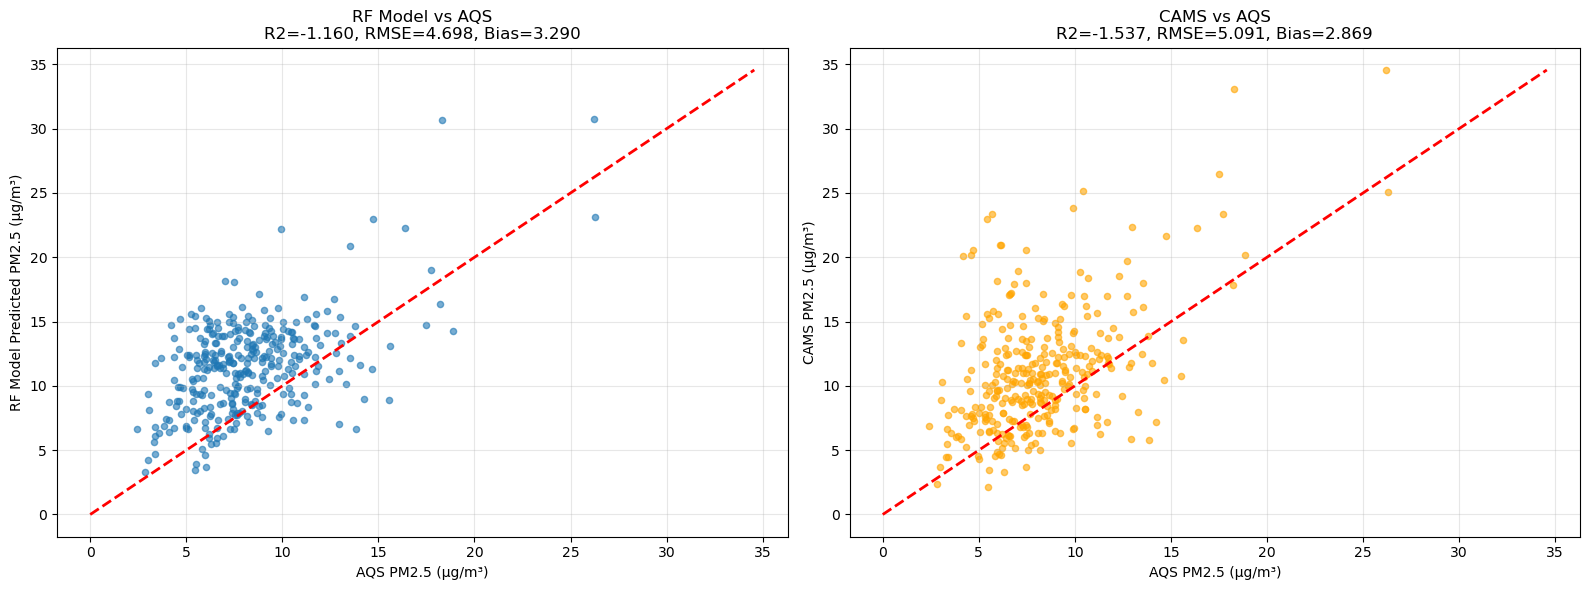

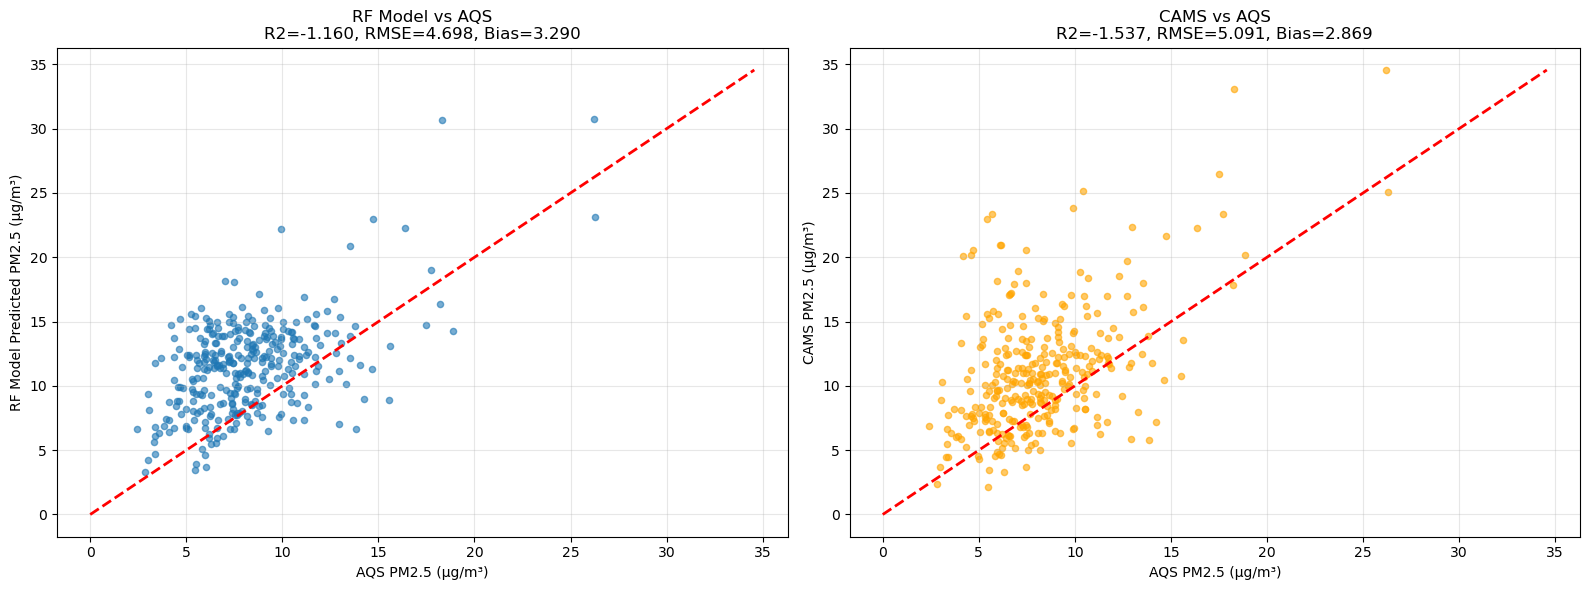

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Determine common axis limits for both plots
max_val = max(merge_data['Arithmetic Mean'].max(), 
              merge_data['rf_pm2p5_pred'].max(), 
              merge_data['pm2p5_test'].max())

# Model predictions vs AQS
axes[0].scatter(merge_data['Arithmetic Mean'], merge_data['rf_pm2p5_pred'], alpha=0.6, s=20)
axes[0].plot([0, max_val], [0, max_val], 'r--', lw=2)
axes[0].set_xlabel('AQS PM2.5 (µg/m³)')
axes[0].set_ylabel('RF Model Predicted PM2.5 (µg/m³)')
axes[0].set_title(f'RF Model vs AQS\nR2={pred_vs_obs_r2:.3f}, RMSE={pred_vs_obs_rmse:.3f}, Bias={pred_vs_obs_bias:.3f}')
axes[0].grid(alpha=0.3)

# CAMS vs AQS (baseline)
axes[1].scatter(merge_data['Arithmetic Mean'], merge_data['pm2p5_test'], alpha=0.6, s=20, color='orange')
axes[1].plot([0, max_val], [0, max_val], 'r--', lw=2)
axes[1].set_xlabel('AQS PM2.5 (µg/m³)')
axes[1].set_ylabel('CAMS PM2.5 (µg/m³)')
axes[1].set_title(f'CAMS vs AQS\nR2={cams_vs_obs_r2:.3f}, RMSE={cams_vs_obs_rmse:.3f}, Bias={cams_vs_obs_bias:.3f}')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()